Modified from _v6

Based on excel toolkit downloaded on 23-11-2020 from the website: https://udmp.ucsf.edu/content/vancomycin-iv. 

"_VancoDosingCalculator_UCSF_2020_0(from website).xlsx"

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Create Functions

## Initial Dose

In [2]:
def initial_dose(Age_yr, Weight_kg, Height_cm, SCr, Female, Method=3):
    """
    Some notes on input:
    Female: No 0, Yes 1
    SCr: serum creatinine in mg/L
    Method: 1 Cockroft-Gault using Total Body Weight (TBW)
            2 Cockroft-Gault using Adjusted Body Weight (ABW)
            3 Cockroft-Gault using Ideal Body Weight (IBW): Not used here
            4 Cockroft-Gault using TBW and SCr rounded up (TBW_RoundSCr_Crcl)
            5 Input Custom CrCl estimation (Forced CrCl): Not used here
    """
    
    # Body data
    Height_inch = Height_cm * 0.393701
    IBW = 45.5+2.3*(Height_inch-60) if Female == 1 else 50+2.3*(Height_inch-60)  #Ideal body weight
    ABW = 0.4*(Weight_kg-IBW)+IBW  #Adjusted body weight
    TBW_IBW = Weight_kg/IBW
    Elderly_Flag = 'Yes' if (Age_yr > 65)&(SCr < 1) else 'No'

#     #==========================
#     # Suggested method: according to UCSF-PK model (ref: C15,C16 on patient_info tab)
#     if TBW_IBW > 1.2: 
#         Method = 2
#     if Elderly_Flag == 'Yes': 
#         Method = 4
#     #==========================
    
    # Parameter calculation
    # Step 1: preliminary values (ml/min)
    TBW_Crcl = (140-Age_yr)*Weight_kg/(72*SCr) if Female == 0 else 0.85*(140-Age_yr)*Weight_kg/(72*SCr)
    AdjBW_Crcl = (140-Age_yr)*ABW/(72*SCr) if Female == 0 else 0.85*(140-Age_yr)*ABW/(72*SCr)
    IBW_Crcl = (140-Age_yr)*IBW/(72*SCr) if Female == 0 else 0.85*(140-Age_yr)*IBW/(72*SCr)
    TBW_RoundSCr_Crcl = (140-Age_yr)*Weight_kg/72 if Female == 0 else 0.85*(140-Age_yr)*Weight_kg/72
    
    #============== (Optional) =============
    # Step 2: Cut off
    TBW_Crcl_max200 = TBW_Crcl if TBW_Crcl <= 200 else 200
    AdjBW_Crcl_max200 = AdjBW_Crcl if AdjBW_Crcl <= 200 else 200
    IBW_Crcl_max200 = IBW_Crcl if IBW_Crcl <= 200 else 200
    TBW_RoundSCr_Crcl_max200 = TBW_RoundSCr_Crcl if TBW_RoundSCr_Crcl <= 200 else 200
    
    TBW_Crcl_max150 = TBW_Crcl if TBW_Crcl <= 150 else 150
    AdjBW_Crcl_max150 = AdjBW_Crcl if AdjBW_Crcl <= 150 else 150
    IBW_Crcl_max150 = IBW_Crcl if IBW_Crcl <= 150 else 150
    TBW_RoundSCr_Crcl_max150 = TBW_RoundSCr_Crcl if TBW_RoundSCr_Crcl <= 150 else 150
        
    # Step 3: Convert ml/min to L/hr
    TBW_Crcl_max200_Lhr = TBW_Crcl_max200 * 60 /1000
    AdjBW_Crcl_max200_Lhr = AdjBW_Crcl_max200 * 60 /1000
    IBW_Crcl_max200_Lhr = IBW_Crcl_max200 * 60 /1000
    TBW_RoundSCr_Crcl_max200_Lhr = TBW_RoundSCr_Crcl_max200 * 60 /1000
    #============== (Optional) =============
    
#     # Step 4: processed Crcl
#     TBW_Crcl_proc = TBW_Crcl * 0.00083 + 0.0044
#     AdjBW_Crcl_proc = AdjBW_Crcl * 0.00083 + 0.0044    
#     IBW_Crcl_proc = IBW_Crcl * 0.00083 + 0.0044    
#     TBW_RoundSCr_Crcl_proc = TBW_RoundSCr_Crcl * 0.00083 + 0.0044
    
    
#     #====== (Plan A) ==============
#     TBW_Crcl_proc = TBW_Crcl_max200 * 0.00083 + 0.0044
#     AdjBW_Crcl_proc = AdjBW_Crcl_max200 * 0.00083 + 0.0044    
#     IBW_Crcl_proc = IBW_Crcl_max200 * 0.00083 + 0.0044    
#     TBW_RoundSCr_Crcl_proc = TBW_RoundSCr_Crcl_max200 * 0.00083 + 0.0044
    
    
    #====== (Plan B) ==============
    TBW_Crcl_proc = TBW_Crcl_max150 * 0.00083 + 0.0044
    AdjBW_Crcl_proc = AdjBW_Crcl_max150 * 0.00083 + 0.0044    
    IBW_Crcl_proc = IBW_Crcl_max150 * 0.00083 + 0.0044    
    TBW_RoundSCr_Crcl_proc = TBW_RoundSCr_Crcl_max150 * 0.00083 + 0.0044
    
    
    
    #Calculate Dose
    # Step 1: Prepare vancomycin parameters
    Vd_vanc =0.7 * Weight_kg
    
    if Method == 1:
        k = TBW_RoundSCr_Crcl_proc
    elif Method == 2:
        k = AdjBW_Crcl_proc
    elif Method == 3:
        k = IBW_Crcl_proc
    elif Method == 4:
        k = TBW_RoundSCr_Crcl_proc
    else:
        print('Invalid Method Chosen')
    
    Clvanc = k * Vd_vanc
    t1_2 = 0.693 / k

    # Step 2: prepare parameters acc to suggested dosing intervals and target trough
    if t1_2 < 6:
        Suggested_T = 6 # Suggested dosing intervals in hours
    elif (t1_2>6)&(t1_2<=10):
        Suggested_T = 8
    elif (t1_2>10)&(t1_2<=18):
        Suggested_T = 12
    elif t1_2 > 18:
        Suggested_T = 24
    
    Chosen_Tau = Suggested_T
    Target_trough = 17.5   # the mean of 15, 20
    nega_kT = - (k * Chosen_Tau)
    
    # Step 3: recommended daily dose
    Vanco_dose = (Target_trough * Vd_vanc) * (1 - np.exp(nega_kT)) / np.exp(nega_kT)
    # Cutoff each injection at 250 - 2000
    if Vanco_dose < 250:
        Vanco_dose = 250 
    elif Vanco_dose > 2000:
        Vanco_dose = 2000
    
    # Not convert into the multiples of 250
    Daily_Dose = round(Vanco_dose * (24/Chosen_Tau), 1)  
    
    return [Daily_Dose, Chosen_Tau]

In [3]:
initial_dose(Age_yr=51, Weight_kg=50, Height_cm=170, SCr=1.2, Female=1, Method=4)

[954.3, 12]

## Subsequent Dose: Single-Level Dose

In [4]:
def single_level_dose(Age_yr, Weight_kg, Height_cm, SCr, Female, Interval_hr, Trough_level, 
                      Prior_Vanco_level, Method = 1):
    """
    Some notes on input:
    Female: No 0, Yes 1
    SCr: serum creatinine in mg/L
    Method: 1 Cockroft-Gault using Total Body Weight (TBW)
            2 Cockroft-Gault using Adjusted Body Weight (ABW)
            3 Cockroft-Gault using Ideal Body Weight (IBW): Not available for now
            4 Cockroft-Gault using TBW and SCr rounded up (TBW_RoundSCr_Crcl)
            5 Input Custom CrCl estimation (Forced CrCl): Not available for now
    Interval_hr: vancomycin frequency in hours
    Trough_level: vancomycin trough serum concentration in mg/L
    Prior_Vanco_level: Prior vancomycin dose in mg
    """
    
    # Body data
    Height_inch = Height_cm * 0.393701
    IBW = 45.5+2.3*(Height_inch-60) if Female == 1 else 50+2.3*(Height_inch-60)  #Ideal body weight
    ABW = 0.4*(Weight_kg-IBW)+IBW  #Adjusted body weight
    TBW_IBW = Weight_kg/IBW
    Elderly_Flag = 'Yes' if (Age_yr > 65)&(SCr < 1) else 'No'

#     #==========================
#     # Suggested method: according to UCSF-PK model (ref: C15,C16 on patient_info tab)
#     if TBW_IBW > 1.2: 
#         Method = 2
#     if Elderly_Flag == 'Yes': 
#         Method = 4
#     #==========================
    
    #Calculate Dose
    # Step 1: Prepare vancomycin parameters
    Vd_vanc =0.7 * Weight_kg
    calc_field = (Trough_level + Prior_Vanco_level/Vd_vanc)/Trough_level
    k = np.log(calc_field)/Interval_hr
    t1_2 = 0.693 / k
    Clvanc = k * Vd_vanc
    
    # Step 2: prepare parameters acc to suggested dosing intervals and target trough
    """Using their suggested dosing intervals (in hours), not ours?"""
    if t1_2 < 6:
        Suggested_T = 6
    elif (t1_2>6)&(t1_2<=10):
        Suggested_T = 8
    elif (t1_2>10)&(t1_2<=18):
        Suggested_T = 12
    elif t1_2 > 18:
        Suggested_T = 24
    
    Chosen_T = Suggested_T
    Target_Trough = 17.5  # the mean of 15, 20
    nega_kT = -(k * Chosen_T)
    
    # Step 3: recommended daily dose
    Vanco_dose = (Target_Trough * Vd_vanc) * (1 - np.exp(nega_kT)) / np.exp(nega_kT)
    # Cutoff each injection at 250 - 2000
    if Vanco_dose < 250:
        Vanco_dose = 250 
    elif Vanco_dose > 2000:
        Vanco_dose = 2000
        
    # Not convert into the multiples of 250
    Daily_Dose = round(Vanco_dose * (24/Chosen_T), 1)  
    
    return [Daily_Dose, Chosen_T]
    

In [5]:
single_level_dose(Age_yr=50, Weight_kg=50, Height_cm=172, SCr=1.2, Female=0, 
                  Interval_hr= 12, Trough_level = 20, 
                  Prior_Vanco_level = 2000)

[2681.8, 8]

# Load Data

In [6]:
finaldatapath = ''
orgdata = pd.read_csv(finaldatapath + 'newcohort_features_addtmp_moddailycohort_priordailydose.csv')
orgdata.sort_values(by=['Case No', 'Date'], ascending=True, inplace=True)
orgdata.shape

(7912, 119)

## Fill In Missing

In [7]:
print(orgdata[orgdata['Height_cm'].isna()].shape)
print(orgdata[orgdata['Height_cm'].isna()].shape[0]/orgdata.shape[0])
print(orgdata[orgdata['Height_cm'].isna()]['Case No'].nunique())
print('==============')
print(orgdata[orgdata['SC_lasttime'].isna()].shape)
print(orgdata[orgdata['SC_lasttime'].isna()].shape[0]/orgdata.shape[0])
print(orgdata[orgdata['SC_lasttime'].isna()]['Case No'].nunique())

(965, 119)
0.12196663296258847
375
(3094, 119)
0.391051567239636
1271


In [8]:
data = orgdata.copy()

# Fill in missing height
tmp_height = data[~data['Height_cm'].isna()].groupby(['Female'])['Height_cm'].mean().reset_index()
data.loc[(data['Female']==1) & (data['Height_cm'].isna()), 
         'Height_cm'] = tmp_height.loc[(tmp_height['Female']==1), 'Height_cm'].values[0]
data.loc[(data['Female']==0) & (data['Height_cm'].isna()), 
         'Height_cm'] = tmp_height.loc[(tmp_height['Female']==0), 'Height_cm'].values[0]
print(data[data['Height_cm'].isna()].shape)

# Fill in missing serum creatinine
sc_mean = np.nanmean(data['SC_lasttime'])
data['SC_lasttime'].fillna(sc_mean, inplace=True)
print(sc_mean* 0.01131222)

(0, 119)
0.9337840813574096


## Create Acceptable Range of Injection

Use target inj level created from [14, 20]

In [9]:
data['tmp_min'] = data['daily accept inj level_mod'].apply(lambda x: min(x * 0.85, x - 250))
data['tmp_max'] = data['daily accept inj level_mod'].apply(lambda x: max(x * 1.15, x + 250))

## Seperate Initial and Subsequent Groups

### Initial Dose Group

In [10]:
cohort_initial = data[(data['Actual Last Vanco Test'].isna())|(data['Actual Prior Daily Dose'].isna())].copy()
cohort_initial['flag'] = cohort_initial['Case No'] + '_' + cohort_initial['Date'].astype(str)

In [11]:
# Remove haemodialysis records
pred_initial = cohort_initial[[
    'Case No', 'Date', 'daily accept inj level_mod', 'in accept range_mod', 'Age',
    'Weight_kg', 'Height_cm', 'SC_lasttime', 'Female',
    'haemodialysis', 'tmp_min', 'tmp_max', 'Daily Dose'
]].copy()
pred_initial['Mod_SC'] = pred_initial['SC_lasttime'] * 0.01131222
pred_initial['pred'] = -1
print(pred_initial.shape)

# Only haemodialysis records
pred_initial_hae = cohort_initial[cohort_initial['haemodialysis']==True][[
    'Case No', 'Date', 'daily accept inj level_mod', 'in accept range_mod', 'Age',
    'Weight_kg', 'Height_cm', 'SC_lasttime', 'Female', 
    'haemodialysis', 'tmp_min', 'tmp_max', 'Daily Dose'
]].copy()
pred_initial_hae['Mod_SC'] = pred_initial_hae['SC_lasttime'] * 0.01131222
pred_initial_hae['pred'] = -1
print(pred_initial_hae.shape)

(1979, 15)
(194, 15)


### Subsequent Dose Group

In [12]:
# Tmp Table 1: has proper vanco test and injection in specific time range
tmp1 = data[~data['Prior Vancomycin Lab Level'].isna()].copy()  
print(tmp1.shape)

# Tmp Table 2: NOT have proper vanco test and injection in specific time range
# need to ensure gap btw vanco test and injection in (5, 28) hours
tmp2 = data[(data['Prior Vancomycin Lab Level'].isna()) & (~data['Actual Last Vanco Test'].isna()) & 
            (~data['tmp_Actual Prior Daily Dose before Actual Prior Vanco Test'].isna()) & 
            (data['Duration Since Actual Prior Daily Dose before Actual Prior Vanco Test'] >
             data['Duration Since Actual Last Vanco Test'])].copy()
tmp2['diff'] = tmp2['Duration Since Actual Prior Daily Dose before Actual Prior Vanco Test'] - tmp2[
    'Duration Since Actual Last Vanco Test']
tmp2 = tmp2[(tmp2['diff']>5) & (tmp2['diff']<28)]
tmp2.drop(columns=['diff'], inplace=True)
print(tmp2.shape)

# Combination
cohort_sub = pd.concat([tmp1, tmp2], axis=0)
print(cohort_sub.shape)

(5363, 121)
(361, 121)
(5724, 121)


#### Patients w/ Vanco Test and Injection in Proper Time Range
Add Prior Injection Dose Based on Prior Injection Frequency (Not the actual one)

In [13]:
tmp0 = data[['Case No', 'Date', 'Freq']].copy()
tmp0.columns = ['Case No', 'Prior Inj Date', 'Prior Freq']

tmp = pd.merge(tmp1, tmp0, on=['Case No'], how='left')
tmp = tmp[tmp['Date'] > tmp['Prior Inj Date']]
print(tmp.shape)

tmp.sort_values(by=['Case No', 'Date', 'Prior Inj Date'],
                ascending=True, inplace=True)
tmp.drop_duplicates(subset=['Case No', 'Date'], keep='last', inplace=True)
print(tmp.shape)

tmp['Prior Inj Dose_Basedon Prior Freq'] = tmp['Prior Daily Dose'] / tmp['Prior Freq']
tmp_comb1 = tmp.drop(columns=['Prior Inj Date'])
print(tmp_comb1.shape)

(20467, 123)
(5363, 123)
(5363, 123)


#### Patients w/o Vanco Test and Injection in Proper Time Range
Add Prior Injection Dose Based on **Current** Injection Frequency (Not the actual one)

In [14]:
tmp2['Prior Inj Dose_Basedon Prior Freq'] = tmp2['Actual Prior Daily Dose'] / tmp2['Freq']
tmp2['Prior Freq'] = tmp2['Freq']
tmp2['Prior Vancomycin Lab Level'] = tmp2['Actual Last Vanco Test']
tmp_comb2 = tmp2.copy()
print(tmp_comb2.shape)

(361, 123)


#### Combination

In [15]:
# Combination
cohort_sub = pd.concat([tmp_comb1, tmp_comb2[tmp_comb1.columns]], axis=0)
print(cohort_sub.shape)

(5724, 123)


In [16]:
# Remove haemodialysis records
pred_sub = cohort_sub[[
    'Case No', 'Date', 'daily accept inj level_mod', 'in accept range_mod', 'Age',
    'Weight_kg', 'Height_cm', 'SC_lasttime', 'Female', 
     'Prior Vancomycin Lab Level', 'Freq', 
    'haemodialysis', 'Vancomycin Lab Level','tmp_min', 'tmp_max',
    'Prior Freq', 'Prior Inj Dose_Basedon Prior Freq', 'Daily Dose'
]].copy()
pred_sub['interval_hr'] = 24/pred_sub['Prior Freq'] # Use prior freq, NOT current freq
pred_sub['Mod_SC'] = pred_sub['SC_lasttime'] * 0.01131222
pred_sub['pred'] = -1
print(pred_sub.shape)

# Only haemodialysis records
pred_sub_hae = cohort_sub[cohort_sub['haemodialysis']==True][[
    'Case No', 'Date', 'daily accept inj level_mod', 'in accept range_mod', 'Age',
    'Weight_kg', 'Height_cm', 'SC_lasttime', 'Female', 
    'Prior Vancomycin Lab Level', 'Freq', 
    'haemodialysis', 'Vancomycin Lab Level', 'tmp_min', 'tmp_max',
    'Prior Freq', 'Prior Inj Dose_Basedon Prior Freq', 'Daily Dose'
]].copy()
pred_sub_hae['interval_hr'] = 24/pred_sub_hae['Prior Freq']
pred_sub_hae['Mod_SC'] = pred_sub_hae['SC_lasttime'] * 0.01131222
pred_sub_hae['pred'] = -1
print(pred_sub_hae.shape)

(5724, 21)
(326, 21)


# Prediction

## Initial Dose

### All

In [17]:
for i in tqdm.tqdm(range(pred_initial.shape[0])):
    pred_initial['pred'].iloc[i] = initial_dose(
        Age_yr=pred_initial['Age'].iloc[i],
        Weight_kg=pred_initial['Weight_kg'].iloc[i],
        Height_cm=pred_initial['Height_cm'].iloc[i],
        SCr=pred_initial['Mod_SC'].iloc[i],
        Female=pred_initial['Female'].iloc[i],
        Method=2
    )[0]
    
pred_initial.loc[pred_initial['haemodialysis']==True, 'pred'] = pred_initial.loc[
    pred_initial['haemodialysis']==True, 'Weight_kg'] * 15

100%|████████████████████████████████████████████████████████████████████████████| 1979/1979 [00:00<00:00, 2703.34it/s]


In [18]:
initial_dose(Age_yr=60, Weight_kg=116, Height_cm=151, SCr=0.248869, Female=1, Method=2)

[6633.9, 6]

In [19]:
pred_initial['pred'].describe()

count    1979.000000
mean     1683.939970
std      1020.750085
min       250.000000
25%       960.600000
50%      1395.800000
75%      2170.650000
max      8000.000000
Name: pred, dtype: float64

**Prediction in acceptable range**

In [20]:
pred_initial['pred_in accept range'] = False
pred_initial.loc[(pred_initial['pred'] > pred_initial['tmp_min']) &
                 (pred_initial['pred'] < pred_initial['tmp_max']),
                 'pred_in accept range'] = True

In [21]:
pred_initial['pred_in accept range'].value_counts(normalize=True)

False    0.717029
True     0.282971
Name: pred_in accept range, dtype: float64

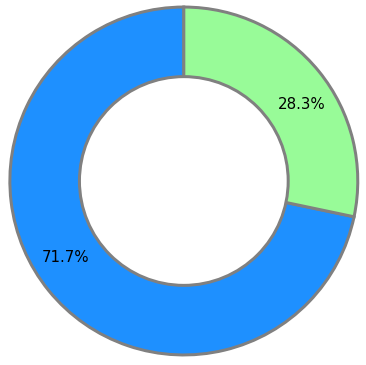

In [22]:
# Initial dosing + Remove
figdata = pd.DataFrame(pred_initial['pred_in accept range'].value_counts().reset_index()).rename(
    columns={'pred_in accept range': 'Records'})

figdata['Label_Rec'] = [str(round(figdata.iloc[0]['Records']/figdata['Records'].sum()*100, 1)) + '%',
                        str(round(figdata.iloc[1]['Records']/figdata['Records'].sum()*100, 1)) + '%']
figdata.sort_values(by=['index'], ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(4,4))

plt.pie(x=figdata['Records'],
        labels=figdata['Label_Rec'],
        colors=['dodgerblue', 'palegreen'],
        startangle=90,
        radius=2,
        labeldistance=0.7,
        textprops = {'fontsize':15, 'color': 'black'},
        wedgeprops = {'edgecolor': 'grey', 'linewidth': 3}
       )

center1 = plt.Circle((0, 0), 1.2, fc='white', color='grey', linewidth=3)
ax.add_artist(center1)

Text(0, 0.5, 'No. of Records')

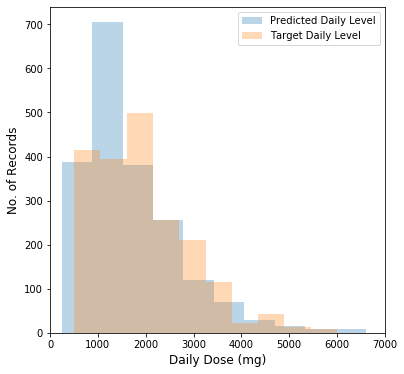

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.hist(pred_initial[pred_initial['pred']<7000]['pred'], alpha=0.3)
plt.hist(pred_initial['daily accept inj level_mod'], alpha=0.3)

ax.set_xlim(0, 7000)
ax.legend(labels=['Predicted Daily Level', 
                  'Target Daily Level'])
ax.set_xlabel('Daily Dose (mg)', size=12)
ax.set_ylabel('No. of Records', size=12)

### Haemodialysis

In [24]:
pred_initial_hae['pred'] = 15 * pred_initial_hae['Weight_kg']

In [25]:
pred_initial_hae['pred_in accept range'] = False
pred_initial_hae.loc[(pred_initial_hae['pred'] > pred_initial_hae['tmp_min']) &
                 (pred_initial_hae['pred'] < pred_initial_hae['tmp_max']),
                 'pred_in accept range'] = True

In [26]:
pred_initial_hae['pred_in accept range'].value_counts(normalize=True)

False    0.556701
True     0.443299
Name: pred_in accept range, dtype: float64

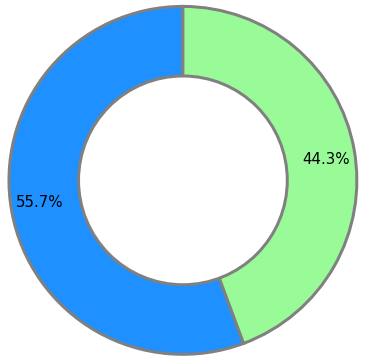

In [27]:
# Initial dosing + Remove
figdata = pd.DataFrame(pred_initial_hae['pred_in accept range'].value_counts().reset_index()).rename(
    columns={'pred_in accept range': 'Records'})

figdata['Label_Rec'] = [str(round(figdata.iloc[0]['Records']/figdata['Records'].sum()*100, 1)) + '%',
                        str(round(figdata.iloc[1]['Records']/figdata['Records'].sum()*100, 1)) + '%']
figdata.sort_values(by=['index'], ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(4,4))

plt.pie(x=figdata['Records'],
        labels=figdata['Label_Rec'],
        colors=['dodgerblue', 'palegreen'],
        startangle=90,
        radius=2,
        labeldistance=0.7,
        textprops = {'fontsize':15, 'color': 'black'},
        wedgeprops = {'edgecolor': 'grey', 'linewidth': 3}
       )

center1 = plt.Circle((0, 0), 1.2, fc='white', color='grey', linewidth=3)
ax.add_artist(center1)

Text(0, 0.5, 'No. of Records')

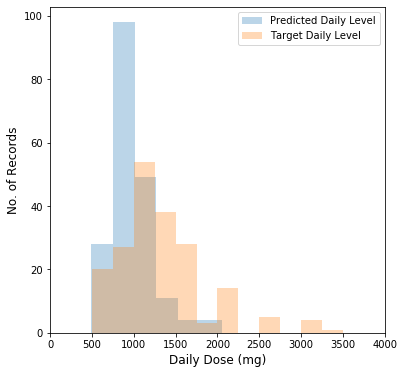

In [28]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.hist(pred_initial_hae['pred'], alpha=0.3, bins=6)
plt.hist(pred_initial_hae['daily accept inj level_mod'], alpha=0.3, bins=12)

ax.set_xlim(0, 4000)
ax.legend(labels=['Predicted Daily Level', 
                  'Target Daily Level'])
ax.set_xlabel('Daily Dose (mg)', size=12)
ax.set_ylabel('No. of Records', size=12)

## Subsequent Dose

### All

In [29]:
for i in tqdm.tqdm(range(pred_sub.shape[0])):
    pred_sub['pred'].iloc[i] = single_level_dose(
        Age_yr=pred_sub['Age'].iloc[i],
        Weight_kg=pred_sub['Weight_kg'].iloc[i],
        Height_cm=pred_sub['Height_cm'].iloc[i],
        SCr=pred_sub['Mod_SC'].iloc[i],
        Female=pred_sub['Female'].iloc[i],
        Interval_hr=pred_sub['interval_hr'].iloc[i],
        Trough_level=pred_sub['Prior Vancomycin Lab Level'].iloc[i],
        Prior_Vanco_level=pred_sub['Prior Inj Dose_Basedon Prior Freq'].iloc[i]
    )[0]
    
pred_sub.loc[pred_sub['haemodialysis']==True, 'pred'] = pred_sub.loc[
    pred_sub['haemodialysis']==True, 'Weight_kg'] * 15

100%|████████████████████████████████████████████████████████████████████████████| 5724/5724 [00:02<00:00, 2376.52it/s]


In [30]:
pred_sub['pred'].describe()

count    5724.000000
mean     2049.892213
std      1057.060918
min       250.000000
25%      1250.000000
50%      1848.600000
75%      2597.125000
max      8000.000000
Name: pred, dtype: float64

In [31]:
single_level_dose(Age_yr=39, Weight_kg=54.3, Height_cm=152, SCr=0.373303, Female=1, 
                  Interval_hr=8, Trough_level =3.7, Prior_Vanco_level = 750)

[7961.1, 6]

**Prediction in acceptable range**

In [32]:
pred_sub['pred_in accept range'] = False
pred_sub.loc[(pred_sub['pred'] > pred_sub['tmp_min']) &
             (pred_sub['pred'] < pred_sub['tmp_max']),
             'pred_in accept range'] = True

In [33]:
pred_sub['pred_in accept range'].value_counts(normalize=True)

True     0.604472
False    0.395528
Name: pred_in accept range, dtype: float64

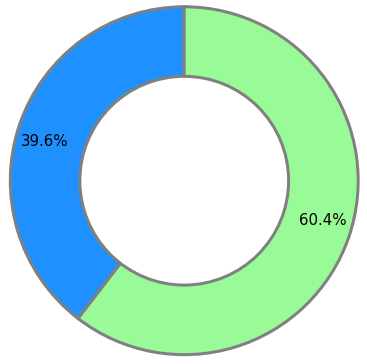

In [34]:
# Initial dosing + Remove
figdata = pd.DataFrame(pred_sub['pred_in accept range'].value_counts().reset_index()).rename(
    columns={'pred_in accept range': 'Records'})

figdata['Label_Rec'] = [str(round(figdata.iloc[0]['Records']/figdata['Records'].sum()*100, 1)) + '%',
                        str(round(figdata.iloc[1]['Records']/figdata['Records'].sum()*100, 1)) + '%']
figdata.sort_values(by=['index'], ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(4,4))

plt.pie(x=figdata['Records'],
        labels=figdata['Label_Rec'],
        colors=['dodgerblue', 'palegreen'],
        startangle=90,
        radius=2,
        labeldistance=0.7,
        textprops = {'fontsize':15, 'color': 'black'},
        wedgeprops = {'edgecolor': 'grey', 'linewidth': 3}
       )

center1 = plt.Circle((0, 0), 1.2, fc='white', color='grey', linewidth=3)
ax.add_artist(center1)

5724 - 5717 = 7


Text(0, 0.5, 'No. of Records')

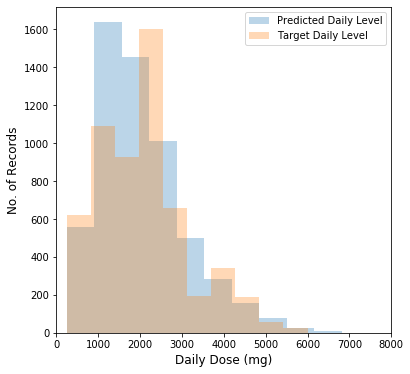

In [35]:
figdata = pred_sub[pred_sub['pred'] <= 7000]
print(str(pred_sub.shape[0]) + ' - ' + str(figdata.shape[0]) + ' = ' + str(
    pred_sub.shape[0] - figdata.shape[0]))

fig, ax = plt.subplots(figsize=(6, 6))

plt.hist(figdata['pred'], alpha=0.3)
plt.hist(figdata['daily accept inj level_mod'], alpha=0.3)

ax.set_xlim(0, 8000)
ax.legend(labels=['Predicted Daily Level', 
                  'Target Daily Level'])
ax.set_xlabel('Daily Dose (mg)', size=12)
ax.set_ylabel('No. of Records', size=12)

### Haemodialysis

In [36]:
pred_sub_hae['pred'] = 15 * pred_sub_hae['Weight_kg']
pred_sub_hae.shape

(326, 21)

In [37]:
pred_sub_hae['pred_in accept range'] = False
pred_sub_hae.loc[(pred_sub_hae['pred'] > pred_sub_hae['tmp_min']) &
                 (pred_sub_hae['pred'] < pred_sub_hae['tmp_max']),
                 'pred_in accept range'] = True

In [38]:
pred_sub_hae['pred_in accept range'].value_counts()

False    212
True     114
Name: pred_in accept range, dtype: int64

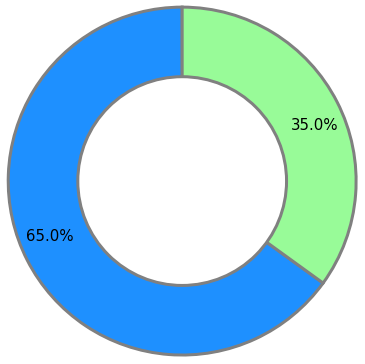

In [39]:
# Initial dosing + Remove
figdata = pd.DataFrame(pred_sub_hae['pred_in accept range'].value_counts().reset_index()).rename(
    columns={'pred_in accept range': 'Records'})

figdata['Label_Rec'] = [str(round(figdata.iloc[0]['Records']/figdata['Records'].sum()*100, 1)) + '%',
                        str(round(figdata.iloc[1]['Records']/figdata['Records'].sum()*100, 1)) + '%']
figdata.sort_values(by=['index'], ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(4,4))

plt.pie(x=figdata['Records'],
        labels=figdata['Label_Rec'],
        colors=['dodgerblue', 'palegreen'],
        startangle=90,
        radius=2,
        labeldistance=0.7,
        textprops = {'fontsize':15, 'color': 'black'},
        wedgeprops = {'edgecolor': 'grey', 'linewidth': 3}
       )

center1 = plt.Circle((0, 0), 1.2, fc='white', color='grey', linewidth=3)
ax.add_artist(center1)

Text(0, 0.5, 'No. of Records')

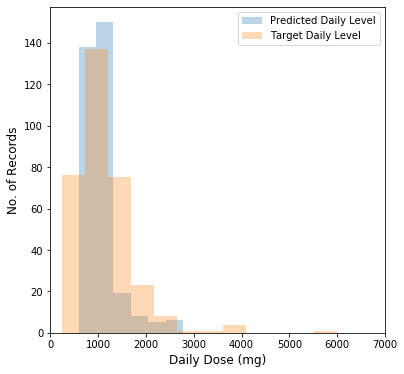

In [40]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.hist(pred_sub_hae['pred'], alpha=0.3, bins=6)
plt.hist(pred_sub_hae['daily accept inj level_mod'], alpha=0.3, bins=12)

ax.set_xlim(0, 7000)
ax.legend(labels=['Predicted Daily Level', 
                  'Target Daily Level'])
ax.set_xlabel('Daily Dose (mg)', size=12)
ax.set_ylabel('No. of Records', size=12)